# Customer segmentation
The aim of customer segmentation is to help businesses direct their attention and marketing stratergies to increase customer satisfaction. 
For this exercise I will continue with the dataset previously used for the churn exercise. 
customer segmentation involves dividing a customer base into distinct groups or segments—based on shared characteristics and behaviors. By understanding the needs and preferences of each segment, businesses can deliver more personalized and effective marketing campaigns, leading to increased customer retention and revenue or in in our case less churn. 
Our current dataset is not ideal for this excercise but I will use it for contiuity purpose. 

## Aim
By applying RFM analysis and K-means clustering to this dataset, I’d like to gain insights into customer behavior and preferences
RFM Analysis is a simple yet powerful method to quantify customer behavior. It evaluates customers based on three key dimensions:
(Tweaking it to suit our dataset)
- Recency (R): How recently did a particular customer make a purchase? In our case this will be how recently a customer interacted. We can use Last Interaction (where lower = better).
- Frequency (F): How often do they make purchases? How often they purchase/interact. We can use Usage Frequency or even Support Calls if relevant.
- Monetary Value (M): How much money do they spend? How much they spend. We have Total Spend. 

We will compute the RFM and map these values to the generally used RFM score scale 1-5.   
Let's start!!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Set directory
os.chdir(r'D:\Fabian\Github\ChurnSeg-Insight')

# 1. Import dataset

In [2]:
rel_path = r'data\customer_churn_dataset-testing-master.csv'
df = pd.read_csv(rel_path)

In [3]:
df.info() # Our data has no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [4]:
df.describe() # 

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,32187.500000,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,18583.317451,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16094.250000,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,32187.500000,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,48280.750000,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,64374.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


# 2. RFM calculation
## 2.1 Prepare the RFM DataFrame

In [5]:
rfm = df[['CustomerID', 'Last Interaction', 'Usage Frequency', 'Total Spend']].copy()

# Rename for clarity
rfm.rename(columns={
    'Last Interaction': 'Recency',
    'Usage Frequency': 'Frequency',
    'Total Spend': 'Monetary'
}, inplace=True)


## 2.2 RFM Scoring
We'll rank each RFM metric into 1-5 (quintiles), where:
- For Recency, lower is better, so we reverse the ranking.
- For Frequency and Monetary, higher is better.

In [6]:
# how many days since the customer's last interaction (lower = better).
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int) # Divides the Recency values into 5 equal-sized groups (quintiles). Customers with the lowest recency (recent activity) get a score of 5.

# How often the customer interacts/purchases (higher = better).
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int) # Assigns a unique rank to each customer to avoid issues with duplicate frequency values (ties) and divides the ranked frequencies into 5 groups.

# Total amount the customer has spent (higher = better).
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int) # Big spenders get a higher score.

# Concatenates the three scores as a string, creating a 3-digit RFM Score, like:
# "555" → Best customers: recent, frequent, high spend.
# "111" → Worst customers: inactive, infrequent, low spend.
# "531" → Recent, frequent, but low spend.
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


### Recency Score Distribution
There's a noticeable peak at R_Score = 5, which means a large portion of customers interacted very recently that's positive.

- The distribution is otherwise fairly balanced, with fewer customers having a score of 3, suggesting fewer customers fall in the "middle ground" for recency.
- R_Score = 1 or 2 customers are less engaged (longer time since last interaction).

### Frequency Score Distribution
Perfectly balanced — roughly equal numbers of customers in each frequency group.  
This is expected because pd.qcut with ranking tends to distribute the data into equal-sized groups, regardless of the underlying distribution.  
The Frequency Score doesn't reveal underlying skew.

### Monetary Score Distribution
Same as Frequency — evenly distributed due to use of qcut.  
Still useful for segmentation, but doesn't indicate if there's a small group of high spenders unless you check raw spend data.  

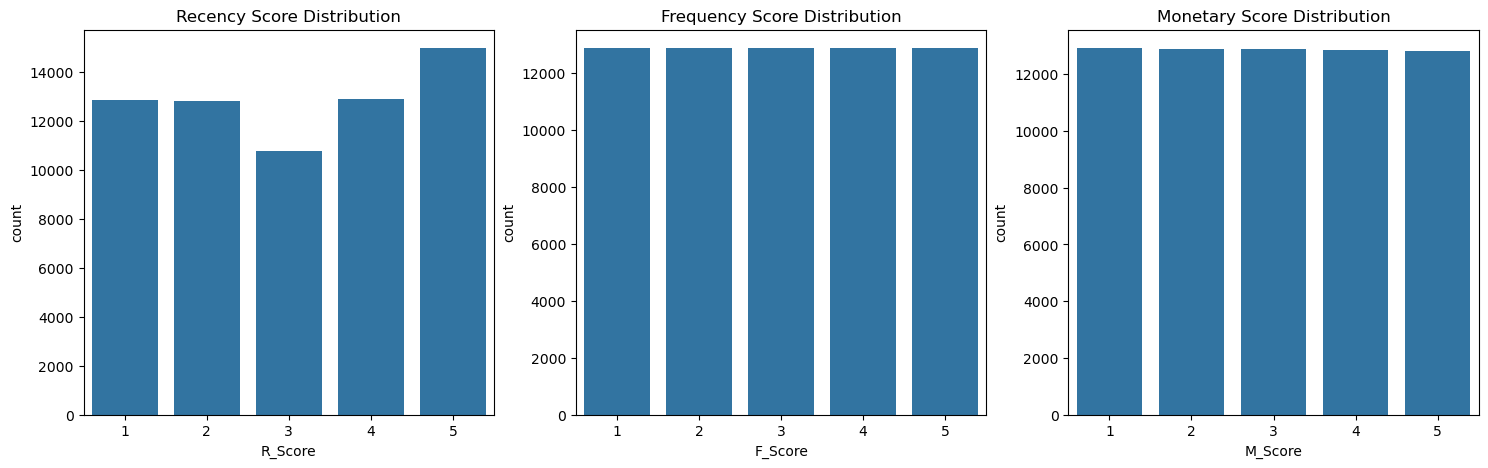

In [7]:
# Separate Histograms for R, F, M Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=rfm, x='R_Score', ax=axes[0])
axes[0].set_title('Recency Score Distribution')

sns.countplot(data=rfm, x='F_Score', ax=axes[1])
axes[1].set_title('Frequency Score Distribution')

sns.countplot(data=rfm, x='M_Score', ax=axes[2])
axes[2].set_title('Monetary Score Distribution')

plt.show()


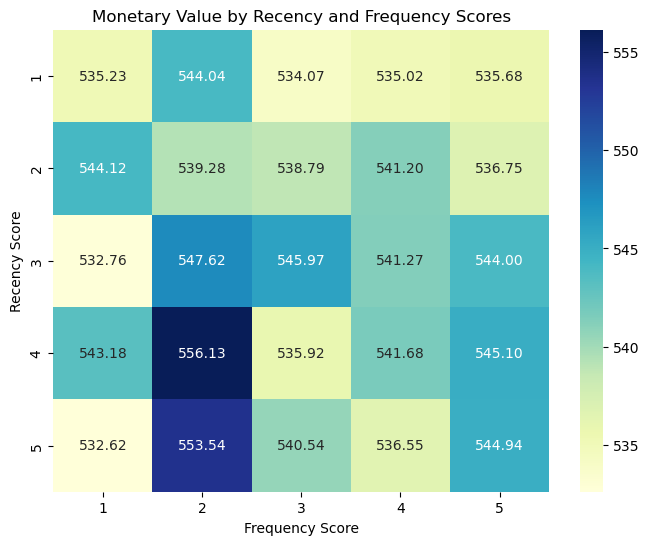

In [8]:
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Monetary Value by Recency and Frequency Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


We can already pull some insights here, but will wait till we run clustering to correctly infer.   

✅ Customers with Recency Score = 4 & Frequency Score = 2
- Highest average spend ($556.13)
- These customers interacted recently and moderately frequently — they are big spenders but not your most frequent interactors.

✅ Recency 5 & Frequency 2, and Recency 5 & Frequency 5
- High average spend ($553.54, $544.94)
- Very recent interaction with either moderate or high frequency — promising, valuable group.

✅ General Trend
- Higher Recency Scores (more recent customers) correlate with higher spend in several cells, though the pattern isn't strictly linear.
- Customers with moderate to high Frequency Scores tend to spend more, but not always — some low-frequency groups still show high spend.

Lets see the results from rfm and clustering.

# 3. Clustering

In [9]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score',]]

We need to find the optimal number of clusters for this let’s run the K-Means algorithm for a range of K values and use the elbow method to pick the optimal K.

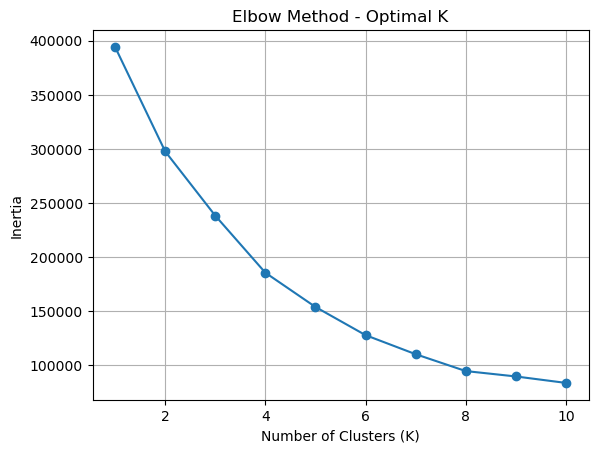

In [10]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Our K is 4 based of the drop in inertia. Lets apply kmeans clustering.

In [11]:
# Assuming we chose 4
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

Let's interpret the clusters to identify customer segmentation. 

In [12]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [13]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,4.100059,4.543354,3.003534
1,1,1.877498,2.901506,1.442216
2,2,1.741061,2.853157,4.094583
3,3,4.402328,1.900313,3.063752


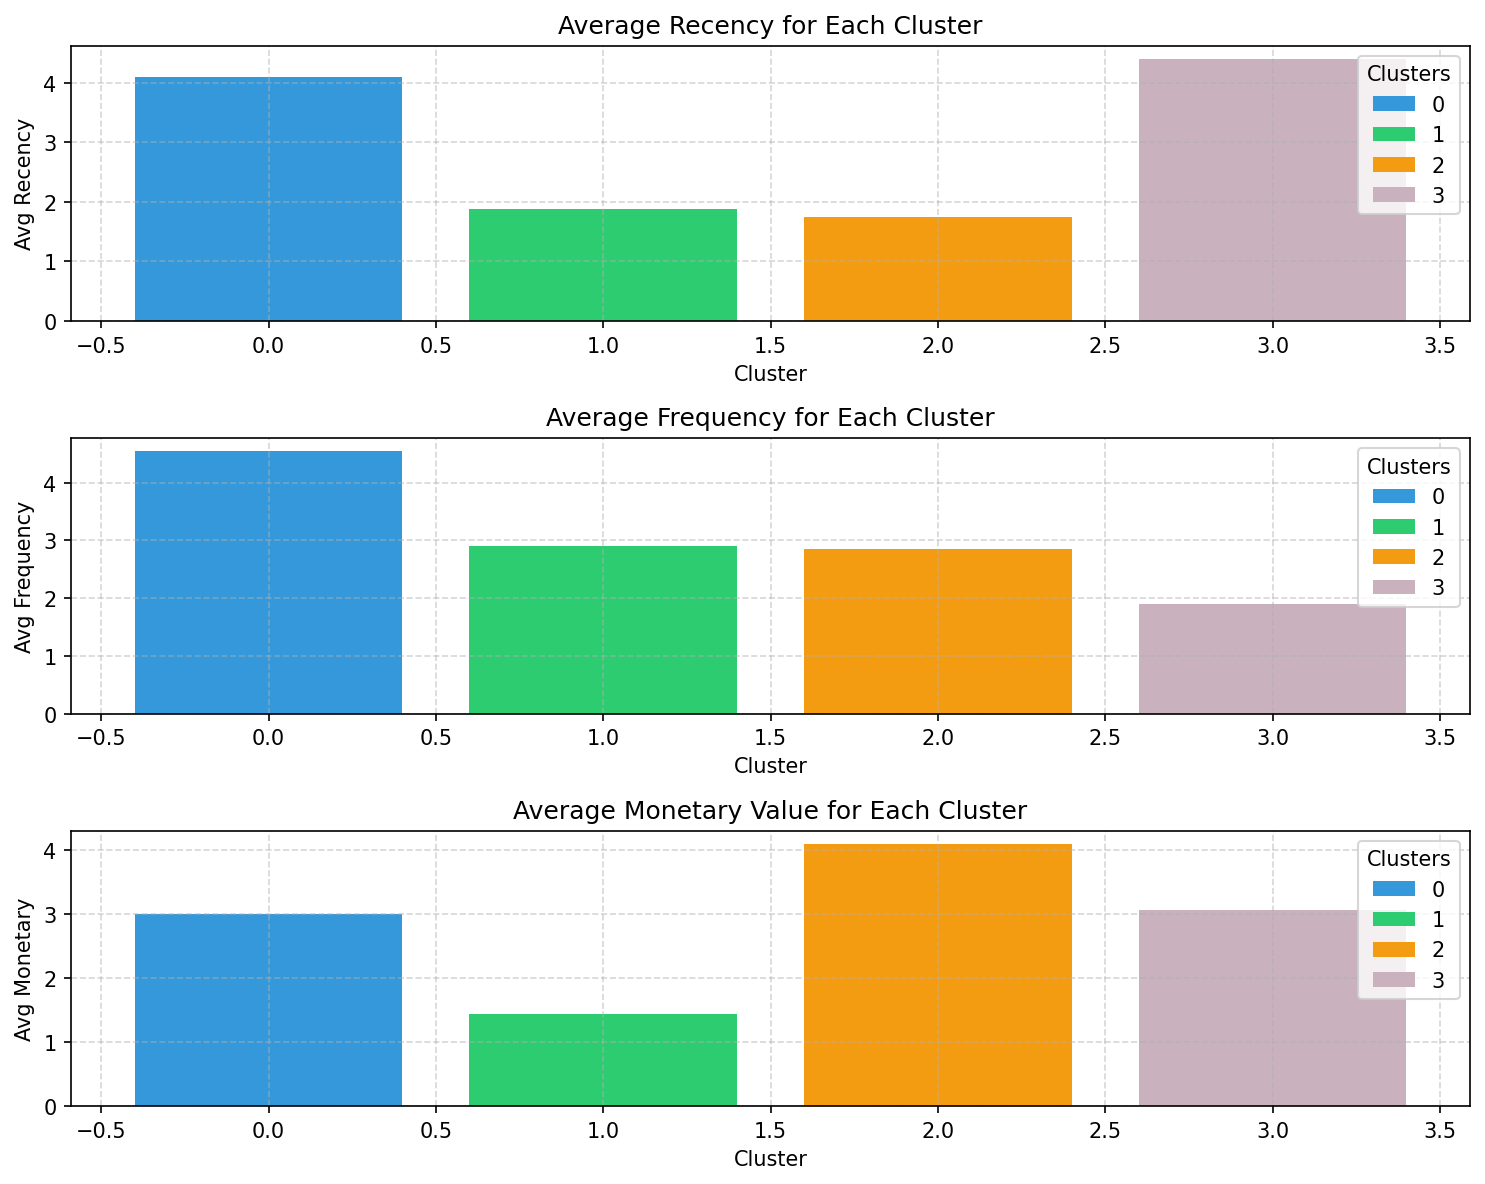

In [14]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

# 4. Cluster Insights from RFM Averages
1. Cluster 0
- High Recency (~4.1): Customers interacted recently.
- High Frequency (~4.5): Customers interact frequently.
- Moderate Monetary (~3.0): Decent spend, but not the highest.

✅ Interpretation:
- Recently active, highly engaged customers.
- They spend moderately — could be encouraged to increase spending.
- Potentially Loyal but Moderate Spenders.

2. Cluster 1
- Low Recency (~1.7): It's been a long time since interaction.
- Moderate Frequency (~2.8): Interacted somewhat often in the past.
- Low Monetary (~1.5): Low spenders.

✅ Interpretation:
- Possibly At-Risk or Dormant Customers.
- Previously engaged, now inactive with low spending history.
- Candidates for reactivation campaigns.

3. Cluster 2
- Low Recency (~1.6): Long time since last interaction.
- Moderate Frequency (~2.9): Some interaction in the past.
- High Monetary (~4.1): High spenders.

✅ Interpretation:
- High-Value but Dormant Customers.
- Spent significantly in the past but now inactive.
- High priority for win-back or re-engagement efforts.

4. Cluster 3
- Very High Recency (~4.5): Very recent interaction.
- Low Frequency (~1.8): Not frequent interactors.
- Moderate Monetary (~3.0): Mid-level spenders.

✅ Interpretation:
- Possibly New Customers — recent activity but low interaction history.
- Show moderate spending potential.
- Focus on nurturing and converting them into loyal customers.

| Cluster | Suggested Segment       | Characteristics                                | Suggested Action            |
| ------- | ----------------------- | ---------------------------------------------- | --------------------------- |
| **0**   | Loyal Moderate Spenders | Recent, frequent, moderate spend               | Upselling, loyalty programs |
| **1**   | At-Risk Low Spenders    | Inactive, moderate past interaction, low spend | Reactivation campaigns      |
| **2**   | High-Value Dormant      | Inactive, some past interaction, high spend    | High-priority win-back      |
| **3**   | New/Recent Customers    | Very recent, low interaction, moderate spend   | Nurturing and engagement    |


# 5. Business implication
### Do the churn rates align with our suggested segment labels?
We have the churn column so we can actually see if our characterization and grouping of clusters shows anything in wether a customer churned or not. 

In [15]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')

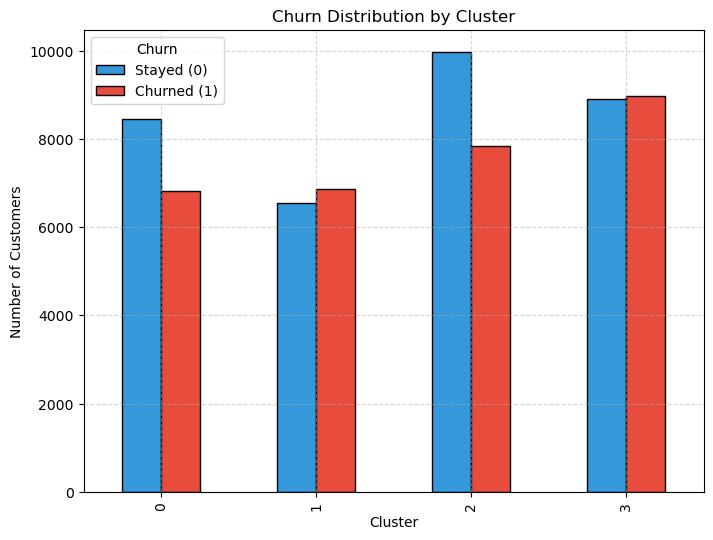

In [16]:
rfm_merge = pd.merge(rfm, df, left_on=['CustomerID'], right_on=['CustomerID'], how='left')
rfm_merge = rfm_merge[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Total Spend', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Score', 'Cluster', 'Churn', 'Gender', 'Subscription Type', 'Contract Length']]
# Group by Cluster and Churn, count occurrences
churn_summary = rfm_merge.groupby(['Cluster', 'Churn']).size().unstack(fill_value=0)
churn_summary.plot(kind='bar', stacked=False, figsize=(8,6), color=['#3498db', '#e74c3c'], edgecolor='black')

plt.title('Churn Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['Stayed (0)', 'Churned (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [18]:
rfm_merge.to_excel('data/after_segmentation.xlsx', index=False)

# 5. Final summary

| Cluster | Suggested Segment       | Churn Observations from Plot                                   | Does the Segment Make Sense?                                                                            |
| ------- | ----------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **0**   | Loyal Moderate Spenders | Churn lower than Cluster 1 and Cluster 3                       | ✅ Yes — they are staying, consistent with loyalty                                                       |
| **1**   | At-Risk Low Spenders    | Churn rate slightly higher than Cluster 0                      | ✅ Yes — at-risk group shows higher churn tendency                                                       |
| **2**   | High-Value Dormant      | Churn lower than Cluster 1 and 3 — surprisingly good retention | ⚠️ Partially — they churn less than expected, suggesting they may not be as dormant or risky as assumed |
| **3**   | New/Recent Customers    | Churn almost equal to non-churn — mixed behavior               | ✅ Yes — new customers often show mixed loyalty, some stay, some leave                                   |

Our original segmentation largely holds, but slight refinement for Cluster 2 would give a more data-aligned story. Cluster 2 should be "High-Value Steady Customers".

# 6. Business strategy
- What should the business strategy be for each segment based on this data?  

| Cluster | Adjusted Segment Name       | Characteristics                                               | Business Strategy                                                                                             |
| ------- | --------------------------- | ------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **0**   | Loyal Moderate Spenders     | Recent, frequent, moderate spend, low churn                   | **Retention & Upselling**: Loyalty rewards, personalized offers to increase spend, referral incentives        |
| **1**   | At-Risk Low Spenders        | Inactive, moderate past interaction, higher churn             | **Reactivation Campaigns**: Targeted discounts, reminders, win-back emails, understand reasons for churn      |
| **2**   | High-Value Steady Customers | Moderate activity, high spend, low churn                      | **Protect & Reward**: VIP treatment, premium support, early access to offers, prevent churn at all costs      |
| **3**   | New/Uncertain Customers     | Recent interaction, low interaction frequency, moderate churn | **Onboarding & Engagement**: Educational content, welcome offers, early satisfaction surveys to build loyalty |


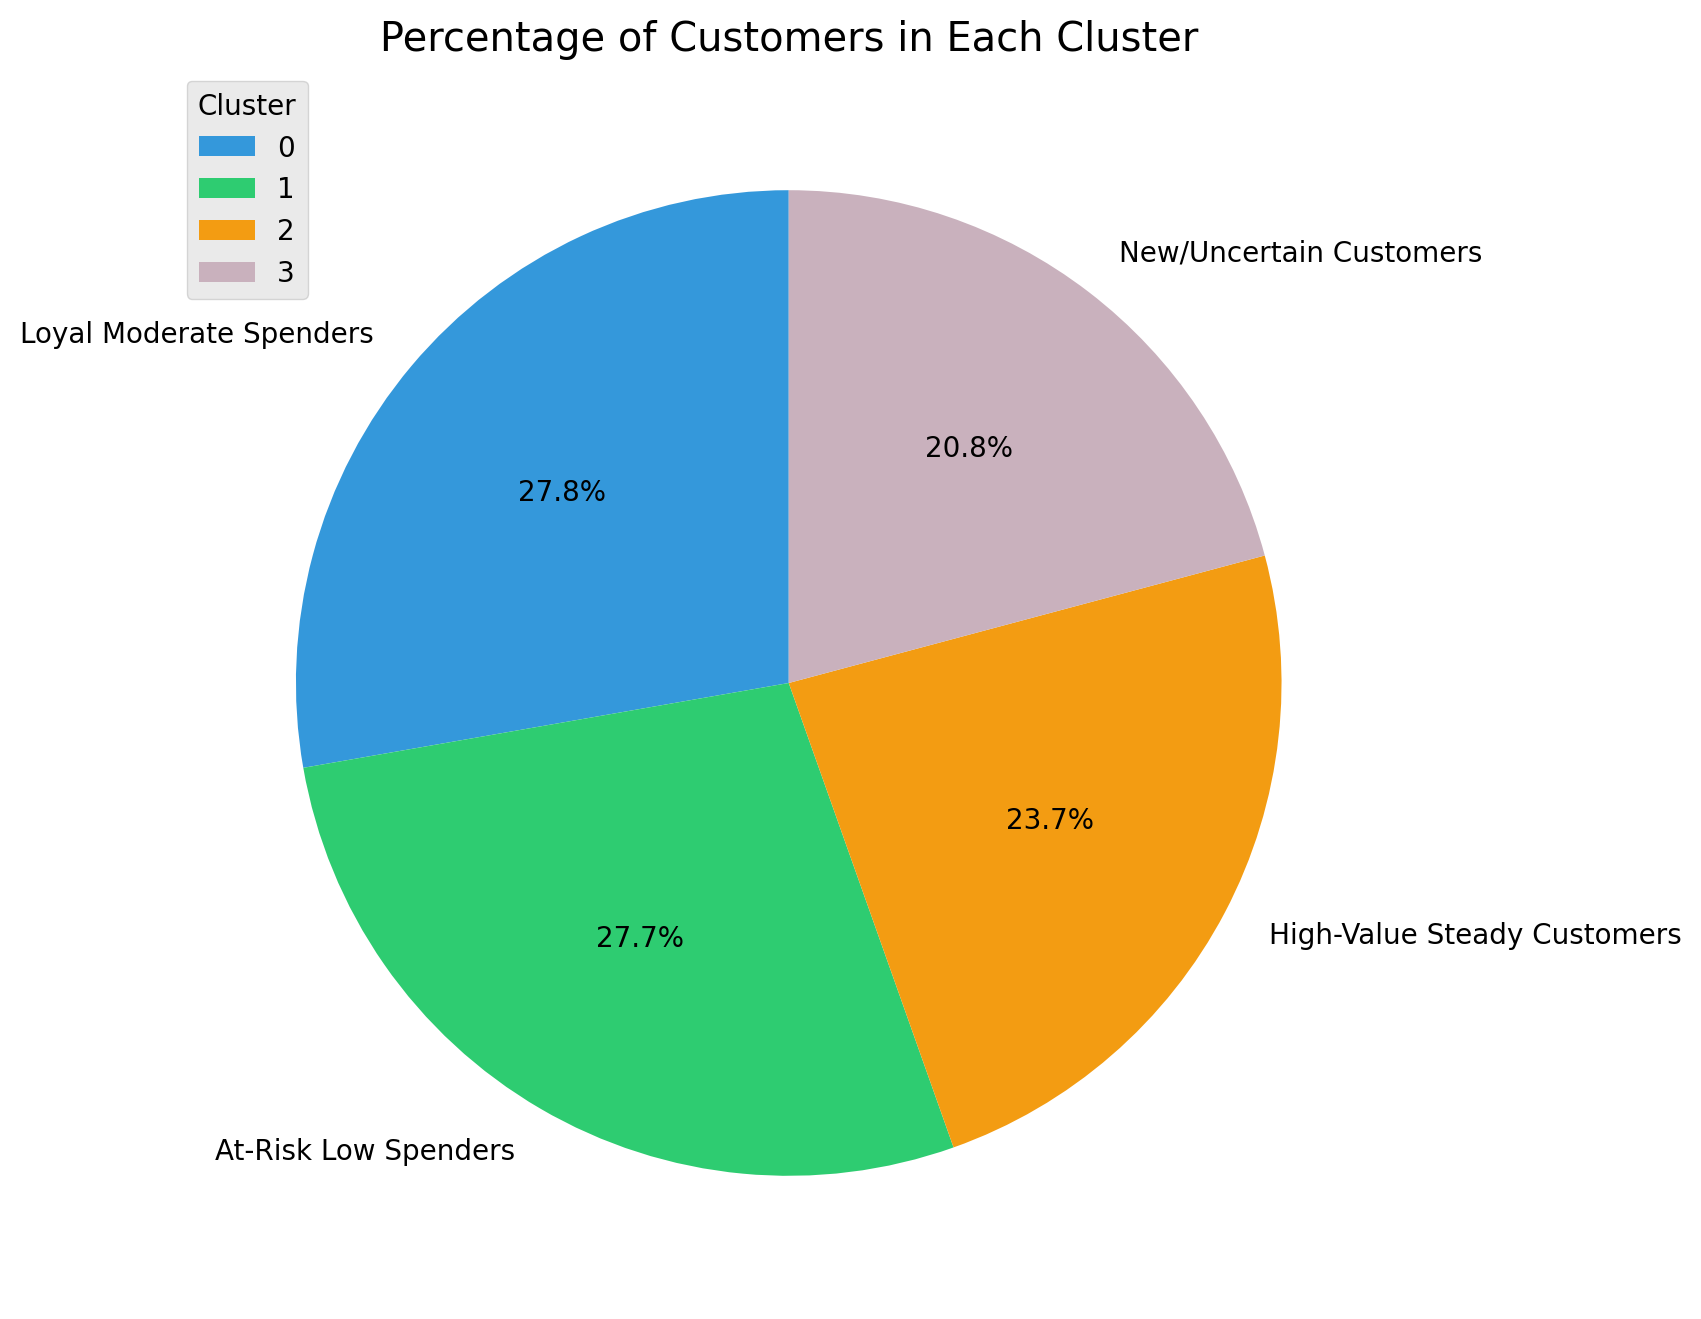

In [ ]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Loyal Moderate Spenders','At-Risk Low Spenders','High-Value Steady Customers','New/Uncertain Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()